In [41]:
import pandas as pd
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [42]:
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))  

In [43]:
accountID = '101-001-9566118-001'
access_token = '541c1d09ea106d47855c4be050f4637d-26d78f76cd5e918ab269a4c23f23ce8d'

In [44]:
client = oandapyV20.API(access_token=access_token)

In [45]:
params = {
          "count": 1000,
          "granularity": "D"}

In [46]:
r = instruments.InstrumentsCandles(instrument="EUR_USD",
                                   params=params)

In [47]:
a = client.request(r)

In [48]:
r.response['candles'][0]['mid']

{'o': '1.05874', 'h': '1.06192', 'l': '1.05205', 'c': '1.05668'}

In [9]:
x = r.response['candles'][0]['time']

In [10]:
x[0:10]

'2015-04-12'

In [11]:
r.response['candles'][0]['volume']

42896

In [12]:
dat = []
for oo in r.response['candles']:
    dat.append([oo['time'], oo['volume'], oo['mid']['o'], oo['mid']['h'], oo['mid']['l'], oo['mid']['c']])

In [13]:
df = pd.DataFrame(dat)
df.columns = ['Date', 'Volume', 'Open', 'High', 'Low', 'Close']

In [14]:
print(type(df["Date"]))

<class 'pandas.core.series.Series'>


In [15]:
get_date = lambda x: x[0:10]

In [16]:
df['Time'] = df.Date.apply(get_date)

In [17]:
df["Time"] = pd.to_datetime(df["Time"])

In [18]:
ind_exchange_data = df.set_index(["Time"], drop=True)

In [19]:
df1 = ind_exchange_data[["Close"]]

In [20]:
df2 = df1.rename(columns={'Close': 'Price'})

In [21]:
df2= df2.astype(float)

In [22]:
df2.head()

,Price
Time,
2015-04-12,1.05668
2015-04-13,1.06547
2015-04-14,1.06841
2015-04-15,1.07614
2015-04-16,1.08068


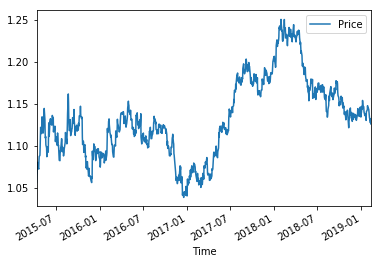

In [23]:
df2.plot()

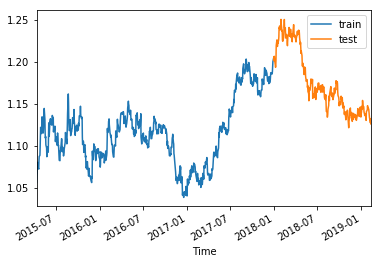

In [24]:
split_date = pd.Timestamp('01-01-2018')

train = df2.loc[:split_date]
test = df2.loc[split_date:]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [25]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [26]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [27]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

Using TensorFlow backend.


In [28]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/200
708/708 [==============================] - 1s 821us/step - loss: 0.0206
Epoch 2/200
708/708 [==============================] - 0s 558us/step - loss: 0.0046
Epoch 3/200
708/708 [==============================] - 0s 571us/step - loss: 0.0027
Epoch 4/200
708/708 [==============================] - 0s 571us/step - loss: 0.0019
Epoch 5/200
708/708 [==============================] - 0s 562us/step - loss: 0.0016
Epoch 6/200
708/708 [==============================] - 0s 566us/step - loss: 0.0015
Epoch 7/200
708/708 [==============================] - 0s 551us/step - loss: 0.0015
Epoch 8/200
708/708 [==============================] - 0s 589us/step - loss: 0.0015
Epoch 9/200
708/708 [==============================] - 0s 610us/step - loss: 0.0014
Epoch 10/200
708/708 [==============================] - 0s 592us/step - loss: 0.0014
Epoch 11/200
708/708 [==============================] - 0s 596us/step - loss: 0.0014
Epoch 12/200
708/708 [==============================] - 0s 665us/step - lo

In [29]:
y_pred_test_ann = model.predict(X_test)
y_train_pred_ann = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_ann)))
r2_train = r2_score(y_train, y_train_pred_ann)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_ann)))
r2_test = r2_score(y_test, y_pred_test_ann)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

The R2 score on the Train set is:	0.926
The Adjusted R2 score on the Train set is:	0.926

The R2 score on the Test set is:	0.960
The Adjusted R2 score on the Test set is:	0.960


In [30]:
model.save('ANN_NonShift.h5')

In [31]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [32]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(7, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

Epoch 1/200
708/708 [==============================] - 1s 2ms/step - loss: 0.0346
Epoch 2/200
708/708 [==============================] - 1s 1ms/step - loss: 0.0073
Epoch 3/200
708/708 [==============================] - 1s 1ms/step - loss: 0.0036
Epoch 4/200
708/708 [==============================] - 1s 1ms/step - loss: 0.0021
Epoch 5/200
708/708 [==============================] - 1s 1ms/step - loss: 0.0017
Epoch 6/200
708/708 [==============================] - 1s 1ms/step - loss: 0.0015
Epoch 7/200
708/708 [==============================] - 1s 1ms/step - loss: 0.0015
Epoch 8/200
708/708 [==============================] - 1s 1ms/step - loss: 0.0014
Epoch 9/200
708/708 [==============================] - 1s 1ms/step - loss: 0.0014
Epoch 10/200
708/708 [==============================] - 1s 1ms/step - loss: 0.0014
Epoch 11/200
708/708 [==============================] - 1s 1ms/step - loss: 0.0014
Epoch 12/200
708/708 [==============================] - 1s 1ms/step - loss: 0.0014
Epoch 13/200


In [33]:
model_lstm.save('LSTM_NonShift.h5')

In [34]:
model_ann = load_model('ANN_NonShift.h5')
model_lstm = load_model('LSTM_NonShift.h5')

In [35]:
score_ann= model_ann.evaluate(X_test, y_test, batch_size=1)
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

291/291 [==============================] - 0s 922us/step


In [36]:
print('ANN: %f'%score_ann)
print('LSTM: %f'%score_lstm)

ANN: 0.001980
LSTM: 0.003930


In [37]:
y_pred_test_ANN = model_ann.predict(X_test)
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

In [38]:
col1 = pd.DataFrame(y_test, columns=['True'])
col2 = pd.DataFrame(y_pred_test_ANN, columns=['ANN_prediction'])
col3 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])
col4 = pd.DataFrame(history.history['loss'], columns=['Loss_ANN'])
col5 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2, col3, col4, col5], axis=1)
results.to_excel('PredictionResults_ANN-LSTM_NonShift.xlsx')

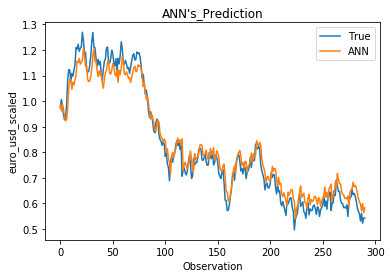

In [39]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_ANN, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('euro_usd_scaled')
plt.legend()
plt.show()

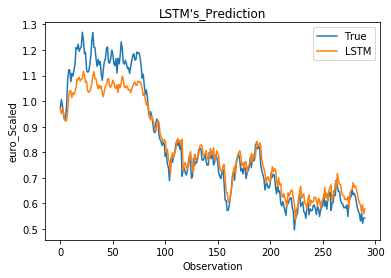

In [40]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('euro_Scaled')
plt.legend()
plt.show()